In [1]:
# -qq to avoid flooding on the output
!unzip -qq fashion-mnist.zip

replace fashion-mnist/valid/3/8083.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [119]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(linewidth=150)
In=Out=""

import PIL
from glob import glob

from sklearn.metrics import f1_score,confusion_matrix, ConfusionMatrixDisplay
import hiddenlayer as hl

from IPython.display import display, clear_output

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device for torch")

Using cuda device for torch


In [122]:
files = {s:np.random.permutation(glob(f"fashion-mnist/{s}/*/*.png")) for s in ["train","valid","test"]}

images = {}

for kind,file_list in files.items():
    Y = []
    X = []
    for file in file_list:
        Y.append(int(file.split("/")[-2]))
        X.append(np.array(PIL.Image.open(file)))
    images[kind] = {"X":X,"Y":Y}
    
tensors = {}

for kind,data in images.items():
    tensor_data = {
        "X":torch.tensor(np.array(data["X"]),dtype=torch.float,device=device),
        "Y":torch.tensor(np.array(data["Y"]),dtype=torch.long, device=device)
    }
    tensors[kind] = tensor_data

In [178]:
batch_size = 256

train_ds = torch.utils.data.TensorDataset(tensors["train"]["X"], tensors["train"]["Y"])
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [193]:
model = nn.Sequential(
    nn.Conv2d( 1, 25, kernel_size=8, stride=1, padding=4,device=device),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    #nn.Dropout(p=0.2),
    #######
    nn.Conv2d(25, 49, kernel_size=8, stride=1, padding=4,device=device),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),
    #nn.Dropout(p=0.2),
    #######
    nn.Conv2d(49, 49, kernel_size=6, stride=1, padding=4,device=device),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),
    #nn.Dropout(p=0.2),
    ######
    nn.Flatten(),
    nn.Linear(49,10,device=device)
)

## Descripción de la red

Esta red tiene tres series de "paquetes", cada uno compuesto de una capa convolucional, una función de activación ReLU, y una capa de max-pooling. Decidí excluir las capas de Dropout, y todo funcionó mejor. 

Las capas convolucionales tienen todas un padding de 4, y tamaños de kernel 8x8, 8x8 y 6x6 respectivamente.

Al final hay una capa que aplana el output de la última capa convolucional, y una capa lineal que debe traducir esos últimos datos a la clasificación final en los 10 tipos de ropa.

In [194]:
test = tensors["train"]["X"][:3].unsqueeze(1)
model(test)

tensor([[  6.6571, -19.6370,   4.9563,  -2.3052,  10.5579,  -8.4982, -14.1273,
         -10.5513,  -4.4481,   2.8450],
        [  6.2400, -12.9290,   1.8593,  -0.9455,   7.1972,  -3.6242,  -9.5356,
          -9.6716,  -3.8664,   1.7837],
        [  6.4036, -14.8011,   2.3314,  -0.5859,   8.9716,  -4.1592, -10.1777,
          -8.7129,  -4.6154,   2.3424]], device='cuda:0',
       grad_fn=<AddmmBackward>)

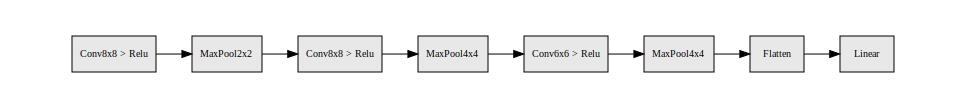

In [195]:
hl.build_graph(model, test)

In [196]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001, weight_decay=0.05)
n_epoch = 10
history = hl.History()
canvas = hl.Canvas()

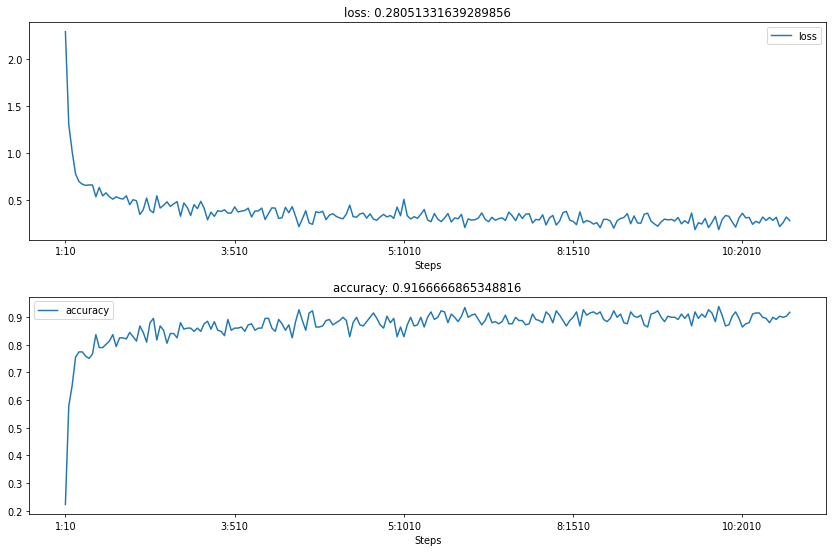

In [197]:
it = 0

for epoch in range(n_epoch):
        for batch_id, (X_train_batch, Y_train_batch) in enumerate(train_dl):
            Xtr = X_train_batch.unsqueeze(1)
            Y_pred = model(Xtr)
            loss = criterion(Y_pred,Y_train_batch)
            Y_pred = torch.argmax(Y_pred, 1)
            f1 = f1_score(Y_train_batch.cpu(), Y_pred.cpu(), average='macro')    
            acc = sum(Y_train_batch == Y_pred)/len(Y_pred)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            it += 1
            if it%10 == 0:
                history.log((epoch+1, it), loss=loss, accuracy=acc)
                with canvas:
                    canvas.draw_plot(history["loss"])
                    canvas.draw_plot(history["accuracy"])

# Resultados

La mayoría de objetos fueron clasificados satisfactoriamente, como se muestra en la matriz de confusión. El único tipo de objeto problemático es el #6, que son camisas, comúnmente clasificadas como camisetas/tops (objeto #0)

In [200]:
Y_pred = model(tensors["test"]["X"].unsqueeze(1))
Y_pred = torch.argmax(Y_pred, 1)

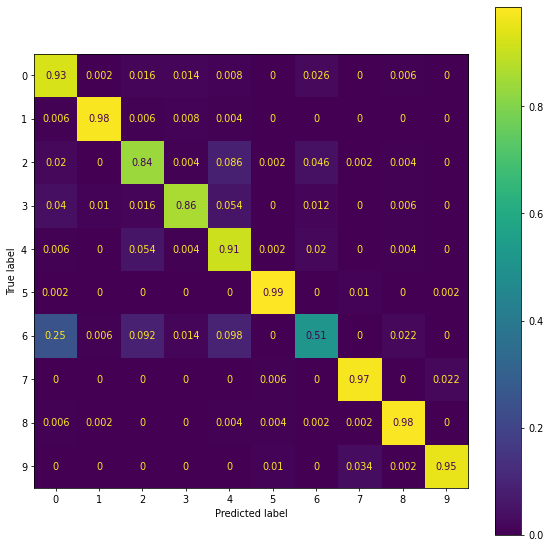

In [201]:
M = confusion_matrix(tensors["test"]["Y"].cpu(),Y_pred.cpu(),normalize='true')
plt.figure(figsize=(10,10))
disp = ConfusionMatrixDisplay(confusion_matrix=M,display_labels=range(10))
disp.plot(ax = plt.gca())